# Topic Modeling on Minimally Processed Text
## Part 00: TF-IDF + NMF

In [1]:
import gc
gc.enable()

In [2]:
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# # Get a sorted list of the objects and their sizes
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [3]:
import pickle

with open("Data/df.pkl", 'rb') as picklefile:
    df = pickle.load(picklefile)

In [4]:
# df.head()

In [5]:
%pylab inline
import numpy 
import matplotlib.pyplot as plt
import sklearn
# Import all of the scikit learn stuff
from __future__ import print_function
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [6]:
docs = df.raw_text

In [8]:
vectorizer = TfidfVectorizer(stop_words = 'english')
dtm = vectorizer.fit_transform(docs) 
# pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names()).head(10)

In [16]:
from sklearn.decomposition import NMF

nmf_model = NMF(2)

dtm_nmf = nmf_model.fit_transform(dtm)
# dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [10]:
dtm.shape

(678, 48391)

So we have 678 documents and the matrix has ~48,000 words associated with it.

In [11]:
dtm_nmf.round(2)

array([[ 0.44,  0.9 ],
       [ 0.  ,  1.  ],
       [ 0.  ,  1.  ],
       ..., 
       [ 0.46,  0.89],
       [ 0.42,  0.91],
       [ 0.42,  0.91]])

In [12]:
dtm_nmf.shape

(678, 2)

And we have two topics now (two columns in the NMF transformed matrix). And the components (word distribution among the two topics) of those two topics are:

In [13]:
nmf_model.components_ #[:,:]

array([[  0.00000000e+00,   5.05654118e-03,   1.79524930e-03, ...,
          2.59337031e-04,   0.00000000e+00,   0.00000000e+00],
       [  1.01012819e-03,   7.23215486e-04,   0.00000000e+00, ...,
          1.29458147e-06,   1.28382704e-03,   6.64947618e-05]])

In [14]:
nmf_model.components_.shape

(2, 48391)

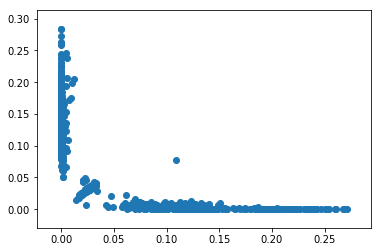

In [17]:
x = dtm_nmf[:,0]
y = dtm_nmf[:,1]
plt.scatter(x,y)

## Part 01: Word Count + LDA  
I am going to follow the guide [here](http://www.shichaoji.com/category/data-cleasing/) for (hopefully) a better topic visuzlization:

In [15]:
from helper import *
import warnings
warnings.filterwarnings('ignore')

In [16]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

In [17]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

stopwords = set(stopwords.words('english'))
punctuation = set(string.punctuation) 
lemmatize = WordNetLemmatizer()

def cleaning(article):
    one = " ".join([i for i in article.lower().split() if i not in stopwords])
    two = "".join(i for i in one if i not in punctuation)
    three = " ".join(lemmatize.lemmatize(i) for i in two.split())
    return three

In [18]:
df2 = df.drop(["_id","end","series","start","url","airdate"], axis=1)

In [19]:
text = df2.applymap(cleaning)['raw_text']
text_list = [i.split() for i in text]
len(text_list)

678

In [20]:
from time import time
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')

In [21]:
df = None
df2 = None
docs = None
del df
del df2
del docs
gc.collect()

14

In [22]:
# gc.get_objects()

In [23]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(text_list)
dictionary.save('dictionary.dict')
print(dictionary)

Dictionary(54161 unique tokens: ['screenplay', 'by', 'gene', 'roddenberry', 'harold']...)


In [25]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

# print(len(doc_term_matrix))
# print(doc_term_matrix[100])

In [30]:
start = time()
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)
print('used: {:.2f}s'.format(time()-start))

used: 2480.87s


In [35]:
with open("Data/ldamodel1.pkl", 'wb') as picklefile:
    pickle.dump(ldamodel, picklefile)

In [32]:
print(ldamodel.print_topics(num_topics=2, num_words=4))

[(3, '0.024*"picard" + 0.019*"riker" + 0.013*"data" + 0.013*"star"'), (5, '0.037*"quark" + 0.014*"rom" + 0.012*"space" + 0.011*"deep"')]


In [34]:
for i in ldamodel.print_topics(): 
    for j in i: print(j)

0
0.010*"ro" + 0.008*"it" + 0.007*"riker" + 0.007*"act" + 0.006*"one" + 0.006*"rev" + 0.006*"amanda" + 0.005*"benny" + 0.005*"look" + 0.005*"continued"
1
0.020*"sisko" + 0.015*"kira" + 0.014*"odo" + 0.014*"space" + 0.012*"obrien" + 0.012*"deep" + 0.011*"act" + 0.010*"dax" + 0.009*"it" + 0.007*"continued"
2
0.038*"worf" + 0.012*"picard" + 0.011*"act" + 0.009*"star" + 0.009*"trek" + 0.008*"klingon" + 0.007*"continued" + 0.007*"look" + 0.007*"rev" + 0.006*"beat"
3
0.024*"picard" + 0.019*"riker" + 0.013*"data" + 0.013*"star" + 0.012*"trek" + 0.011*"act" + 0.009*"geordi" + 0.008*"beverly" + 0.008*"continued" + 0.007*"it"
4
0.020*"kirk" + 0.019*"archer" + 0.012*"spock" + 0.012*"it" + 0.010*"tpol" + 0.010*"tucker" + 0.010*"captain" + 0.006*"reed" + 0.006*"one" + 0.006*"im"
5
0.037*"quark" + 0.014*"rom" + 0.012*"space" + 0.011*"deep" + 0.010*"it" + 0.010*"act" + 0.008*"bashir" + 0.008*"nine" + 0.007*"rev" + 0.007*"odo"
6
0.022*"picard" + 0.019*"data" + 0.011*"star" + 0.011*"riker" + 0.011*"tro

Brilliant! My topics are based on characters that are in the respective series! Not a very useful information, but it LDA works pretty well. Let's see if we can visuzlize it.

In [36]:
ldamodel.save('topic.model')

In [1]:
from gensim.models import LdaModel
loading = LdaModel.load('topic.model')

In [2]:
print(loading.print_topics(num_topics=2, num_words=4))

[(3, '0.024*"picard" + 0.019*"riker" + 0.013*"data" + 0.013*"star"'), (7, '0.022*"janeway" + 0.013*"it" + 0.012*"chakotay" + 0.011*"paris"')]


In [3]:
def pre_new(doc):
    one = cleaning(doc).split()
    two = dictionary.doc2bow(one)
    return two

In [4]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [5]:
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
lda = gensim.models.LdaModel.load('topic.model')

In [6]:
data = pyLDAvis.gensim.prepare(lda, c, d)
data

/home/aleksod/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      16.079510        1       1  0.153091 -0.070547
1      16.069359        1       2 -0.047784 -0.029306
3      16.006490        1       3  0.010069  0.077884
4      14.751880        1       4  0.137196 -0.052204
6      12.244543        1       5  0.006407  0.073103
8      10.911350        1       6 -0.061896 -0.027519
5       4.842541        1       7 -0.093113 -0.064796
2       4.270191        1       8 -0.042592  0.078086
9       3.589296        1       9  0.023855  0.111859
0       1.234840        1      10 -0.085234 -0.096560, topic_info=      Category          Freq        Term         Total  loglift  logprob
term                                                                    
4018   Default  26348.000000      picard  26348.000000  30.0000  30.0000
4027   Default  15842.000000        worf  15842.000000  29.0000  29.0000
28715  Default  10597.000000       quark  10597.000000  28.0000  28.0000
16158  Default  12211.000000     janeway  12211.000000  27.0000  27.0000
668    Default  10444.000000        kirk  10444.000000  26.0000  26.0000
28777  Default  17465.000000       sisko  17465.000000  25.0000  25.0000
4021   Default  16606.000000       riker  16606.000000  24.0000  24.0000
15669  Default   9895.000000      archer   9895.000000  23.0000  23.0000
3213   Default  17382.000000        data  17382.000000  22.0000  22.0000
27     Default  13912.000000        deep  13912.000000  21.0000  21.0000
28781  Default  10660.000000      bashir  10660.000000  20.0000  20.0000
1570   Default  24421.000000         act  24421.000000  19.0000  19.0000
28787  Default  10626.000000         odo  10626.000000  18.0000  18.0000
28779  Default  10897.000000        kira  10897.000000  17.0000  17.0000
18     Default  18686.000000       space  18686.000000  16.0000  16.0000
470    Default   6329.000000       spock   6329.000000  15.0000  15.0000
21249  Default   6447.000000    chakotay   6447.000000  14.0000  14.0000
5753   Default   6018.000000       paris   6018.000000  13.0000  13.0000
4014   Default  16036.000000         rev  16036.000000  12.0000  12.0000
21221  Default   5768.000000         emh   5768.000000  11.0000  11.0000
21220  Default   5767.000000       tuvok   5767.000000  10.0000  10.0000
3985   Default  14680.000000        trek  14680.000000   9.0000   9.0000
32     Default  15652.000000        star  15652.000000   8.0000   8.0000
4082   Default  17070.000000   continued  17070.000000   7.0000   7.0000
4026   Default   9638.000000      geordi   9638.000000   6.0000   6.0000
1135   Default  10073.000000        nine  10073.000000   5.0000   5.0000
28822  Default   8150.000000         dax   8150.000000   4.0000   4.0000
15668  Default   4999.000000        tpol   4999.000000   3.0000   3.0000
28783  Default  11444.000000      obrien  11444.000000   2.0000   2.0000
15708  Default   4892.000000      tucker   4892.000000   1.0000   1.0000
...        ...           ...         ...           ...      ...      ...
40216  Topic10    419.461920          ro    971.327429   3.5545  -4.6258
16821  Topic10     65.809345  preemptive     77.629776   4.2290  -6.4781
16268  Topic10     66.845787     outcast     80.329607   4.2105  -6.4624
33722  Topic10    192.213065   eddington    677.464899   3.1345  -5.4062
709    Topic10    107.740856          lt    221.846121   3.6720  -5.9851
5906   Topic10     88.503688       angel    187.622651   3.6428  -6.1818
4021   Topic10    314.460823       riker  16606.719380   0.4275  -4.9140
37     Topic10    328.758018          it  31642.787755  -0.1727  -4.8695
30     Topic10    278.113168         one  21016.492056   0.0692  -5.0368
1570   Topic10    287.645688         act  24421.742999  -0.0473  -5.0031
4014   Topic10    253.459748         rev  16036.502927   0.2468  -5.1296
559    Topic10    222.494149        look  16004.330879   0.1185  -5.2599
4082   Topic10    217.01

In [7]:
pyLDAvis.save_html(data,'vis1.html')

This is a pretty good separation. Unfortunately, it is based mostly on very specific TV show / movies terms. Therefore, I will need to remove those if I want better results.